In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

fast_mode = False

In [2]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
test_data = test_data
if fast_mode:
    test_data = test_data[1:3]
len(train_data), len(test_data)

(444, 200)

ii 0
0 1 2 3 4 5 6 7 8 9 9 torch.Size([100, 128, 192, 192])
10 11 12 13 14 15 16 17 18 19 19 torch.Size([100, 128, 192, 192])
20 21 22 23 24 25 26 27 28 29 29 torch.Size([100, 128, 192, 192])
30 31 32 33 34 35 36 37 38 39 39 torch.Size([100, 128, 192, 192])
40 41 42 43 44 45 46 47 48 49 49 torch.Size([100, 128, 192, 192])


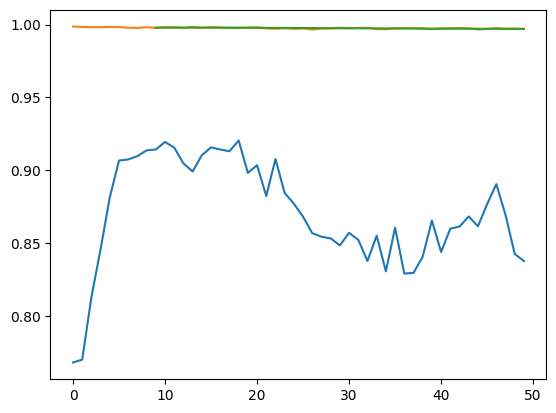

50 51 52 53 54 55 56 57 58 59 59 torch.Size([100, 128, 192, 192])
60 61 62 63 64 65 66 67 68 69 69 torch.Size([100, 128, 192, 192])
70 71 72 73 74 75 76 77 78 79 79 torch.Size([100, 128, 192, 192])
80 81 82 83 84 85 86 87 88 89 89 torch.Size([100, 128, 192, 192])
90 91 92 93 94 95 96 97 98 99 99 torch.Size([100, 128, 192, 192])


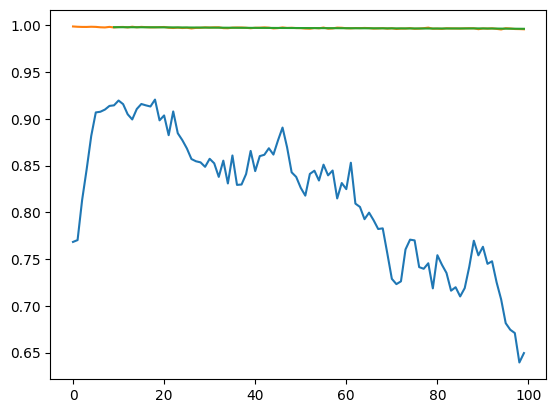

100 101 102 103 104 105 106 107 108 109 109 torch.Size([100, 128, 192, 192])
110 111 112 113 114 115 116 117 118 119 119 torch.Size([100, 128, 192, 192])
120 121 122 123 124 125 126 127 128 129 129 torch.Size([100, 128, 192, 192])
130 131 132 133 134 135 136 137 138 139 139 torch.Size([100, 128, 192, 192])
140 141 142 143 144 145 146 147 148 149 149 torch.Size([100, 128, 192, 192])


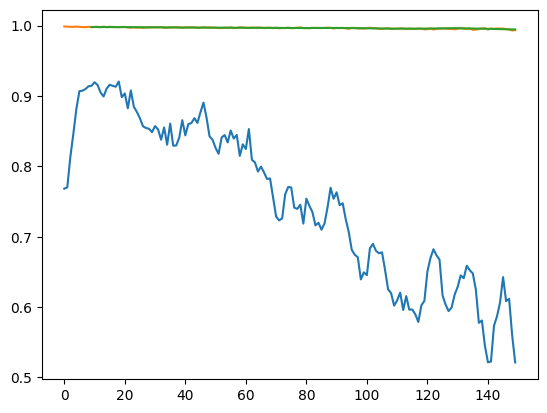

150 151 152 153 154 155 156 157 158 159 159 torch.Size([100, 128, 192, 192])
160 161 162 163 164 165 166 167 168 169 169 torch.Size([100, 128, 192, 192])
170 171 172 173 174 175 176 177 178 179 179 torch.Size([100, 128, 192, 192])
180 181 182 183 184 185 186 187 188 189 189 torch.Size([100, 128, 192, 192])
190 191 192 193 194 195 196 197 198 199 199 torch.Size([100, 128, 192, 192])


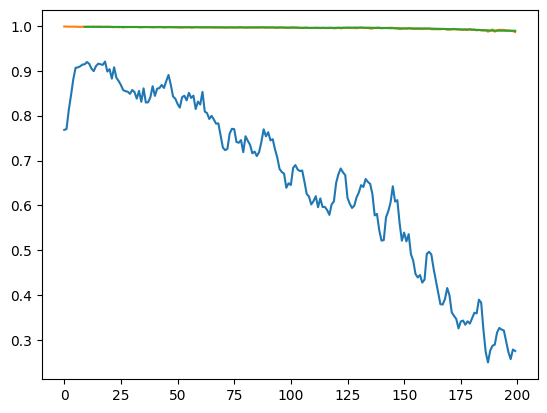

200 201 202 203 204 205 206 207 208 209 209 torch.Size([100, 128, 192, 192])
210 211 212 213 214 215 216 217 218 219 219 torch.Size([100, 128, 192, 192])
220 221 222 223 224 225 226 227 228 229 229 torch.Size([100, 128, 192, 192])
230 231 232 233 234 235 236 237 238 239 239 torch.Size([100, 128, 192, 192])
240 241 242 243 244 245 246 247 248 249 249 torch.Size([100, 128, 192, 192])


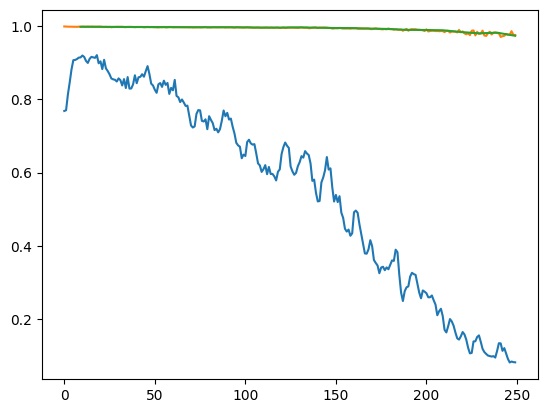

250 251 252 253 254 255 256 257 258 259 259 torch.Size([100, 128, 192, 192])
260 261 262 263 264 265 266 267 268 269 269 torch.Size([100, 128, 192, 192])
270 271 272 273 274 275 276 277 278 279 279 torch.Size([100, 128, 192, 192])
280 281 282 283 284 285 286 287 288 289 289 torch.Size([100, 128, 192, 192])
290 291 292 293 294 295 296 297 298 299 299 torch.Size([100, 128, 192, 192])


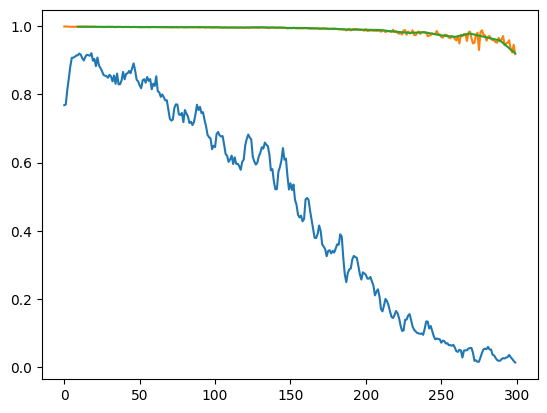

300 301 302 303 304 305 306 307 308 309 309 torch.Size([100, 128, 192, 192])
310 311 312 313 314 315 316 317 318 319 319 torch.Size([100, 128, 192, 192])
320 321 322 323 324 325 326 327 328 329 329 torch.Size([100, 128, 192, 192])
330 331 332 333 334 335 336 337 338 339 339 torch.Size([100, 128, 192, 192])
340 341 342 343 344 345 346 347 348 349 349 torch.Size([100, 128, 192, 192])


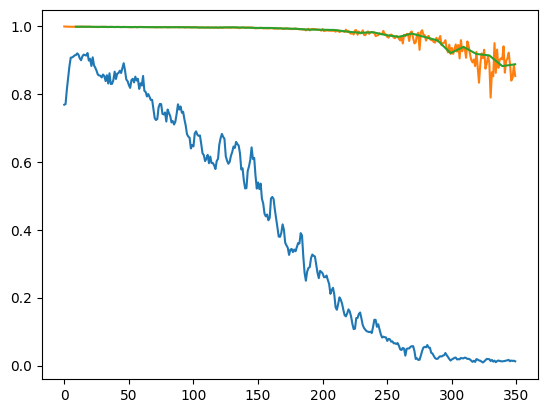

350 351 352 353 354 355 356 357 358 359 359 torch.Size([100, 128, 192, 192])
360 361 362 363 364 365 366 367 368 369 369 torch.Size([100, 128, 192, 192])
370 371 372 373 374 375 376 377 378 379 379 torch.Size([100, 128, 192, 192])
380 381 382 383 384 385 386 387 388 389 389 torch.Size([100, 128, 192, 192])
390 391 392 393 394 395 396 397 398 399 399 torch.Size([100, 128, 192, 192])


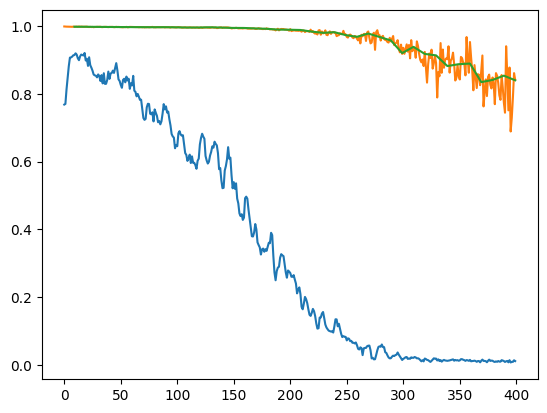

400 401 402 403 404 405 406 407 408 409 409 torch.Size([100, 128, 192, 192])
410 411 412 413 414 415 416 417 418 419 419 torch.Size([100, 128, 192, 192])
420 421 422 423 424 425 426 427 428 429 429 torch.Size([100, 128, 192, 192])
430 431 432 433 434 435 436 437 438 439 439 torch.Size([100, 128, 192, 192])
440 441 442 443 444 445 446 447 448 449 449 torch.Size([100, 128, 192, 192])


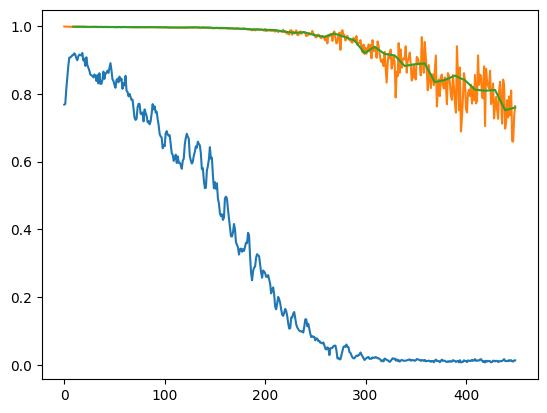

450 451 452 453 454 455 456 457 458 459 459 torch.Size([100, 128, 192, 192])
460 461 462 463 464 465 466 467 468 469 469 torch.Size([100, 128, 192, 192])
470 471 472 473 474 475 476 477 478 479 479 torch.Size([100, 128, 192, 192])
480 481 482 483 484 485 486 487 488 489 489 torch.Size([100, 128, 192, 192])
490 491 492 493 494 495 496 497 498 499 499 torch.Size([100, 128, 192, 192])


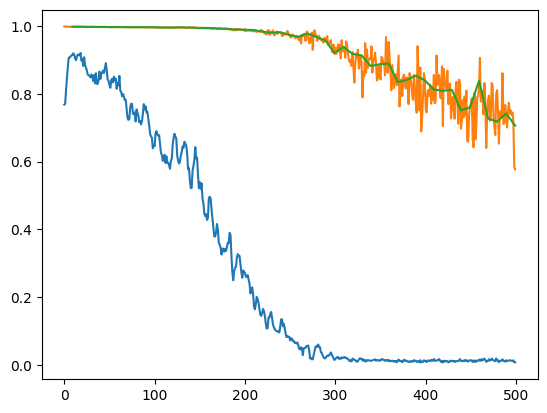

500 501 502 503 504 505 506 507 508 509 509 torch.Size([100, 128, 192, 192])
510 511 512 513 514 515 516 517 518 519 519 torch.Size([100, 128, 192, 192])
520 521 522 523 524 525 526 527 528 529 529 torch.Size([100, 128, 192, 192])
530 531 532 533 534 535 536 537 538 539 539 torch.Size([100, 128, 192, 192])
540 541 542 543 544 545 546 547 548 549 549 torch.Size([100, 128, 192, 192])


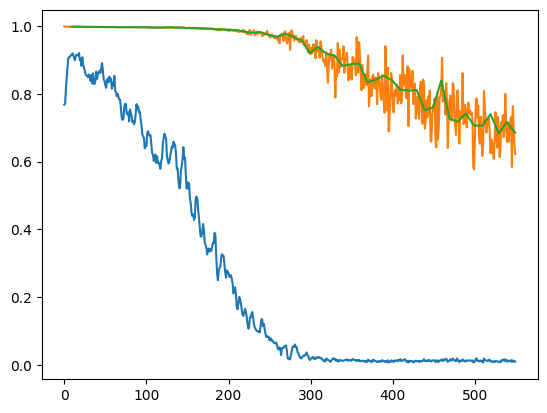

550 551 552 553 554 555 556 557 558 559 559 torch.Size([100, 128, 192, 192])
560 561 562 563 564 565 566 567 568 569 569 torch.Size([100, 128, 192, 192])
570 571 572 573 574 575 576 577 578 579 579 torch.Size([100, 128, 192, 192])
580 581 582 583 584 585 586 587 588 589 589 torch.Size([100, 128, 192, 192])
590 591 592 593 594 595 596 597 598 599 599 torch.Size([100, 128, 192, 192])


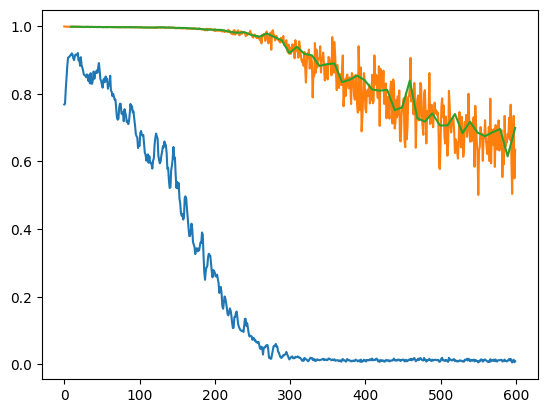

600 601 602 603 604 605 606 607 608 609 609 torch.Size([100, 128, 192, 192])
610 611 612 613 614 615 616 617 618 619 619 torch.Size([100, 128, 192, 192])
620 621 622 623 624 625 626 627 628 629 629 torch.Size([100, 128, 192, 192])
630 631 632 633 634 635 636 637 638 639 639 torch.Size([100, 128, 192, 192])
640 641 642 643 644 645 646 647 648 649 649 torch.Size([100, 128, 192, 192])


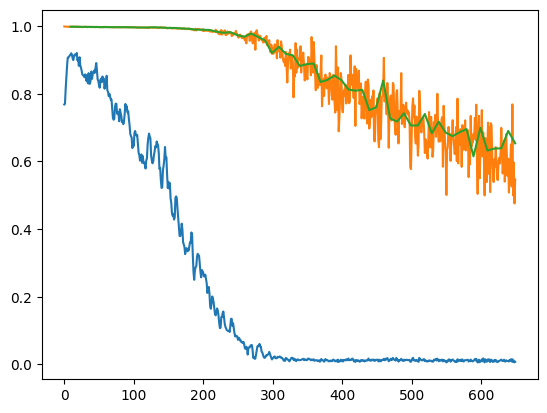

650 651 652 653 654 655 656 657 658 659 659 torch.Size([100, 128, 192, 192])
660 661 662 663 664 665 666 667 668 669 669 torch.Size([100, 128, 192, 192])
670 671 672 673 674 675 676 677 678 679 679 torch.Size([100, 128, 192, 192])
680 681 682 683 684 685 686 687 688 689 689 torch.Size([100, 128, 192, 192])
690 691 692 693 694 695 696 697 698 699 699 torch.Size([100, 128, 192, 192])


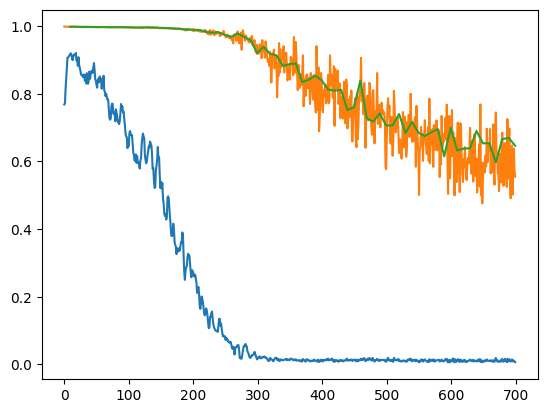

700 701 702 703 704 705 706 707 708 709 709 torch.Size([100, 128, 192, 192])
710 711 712 713 714 715 716 717 718 719 719 torch.Size([100, 128, 192, 192])
720 721 722 723 724 725 726 727 728 729 729 torch.Size([100, 128, 192, 192])
730 731 732 733 734 735 736 737 738 739 739 torch.Size([100, 128, 192, 192])
740 741 742 743 744 745 746 747 748 749 749 torch.Size([100, 128, 192, 192])


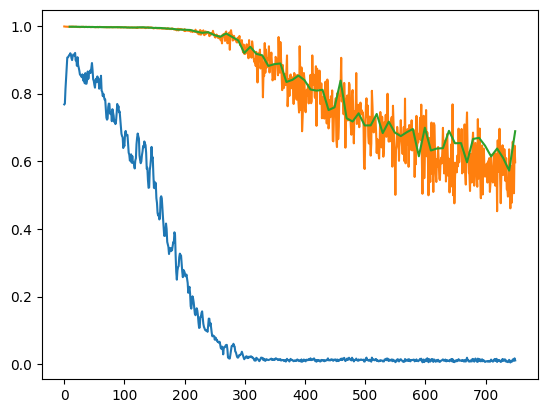

750 751 752 753 754 755 756 757 758 759 759 torch.Size([100, 128, 192, 192])
760 761 762 763 764 765 766 767 768 769 769 torch.Size([100, 128, 192, 192])
770 771 772 773 774 775 776 777 778 779 779 torch.Size([100, 128, 192, 192])
780 781 782 783 784 785 786 787 788 789 789 torch.Size([100, 128, 192, 192])
790 791 792 793 794 795 796 797 798 799 799 torch.Size([100, 128, 192, 192])


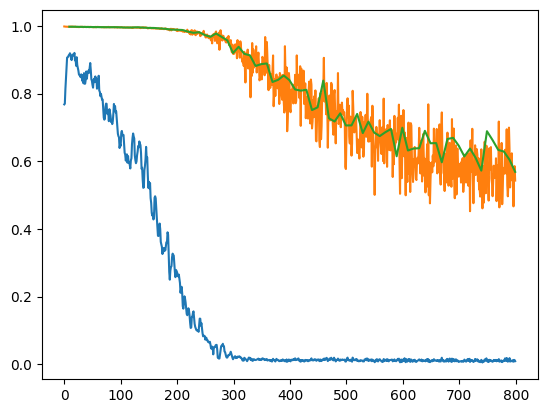

800 801 802 803 804 805 806 807 808 809 809 torch.Size([100, 128, 192, 192])
810 811 812 813 814 815 816 817 818 819 819 torch.Size([100, 128, 192, 192])
820 821 822 823 824 825 826 827 828 829 829 torch.Size([100, 128, 192, 192])
830 831 832 833 834 835 836 837 838 839 839 torch.Size([100, 128, 192, 192])
840 841 842 843 844 845 846 847 848 849 849 torch.Size([100, 128, 192, 192])


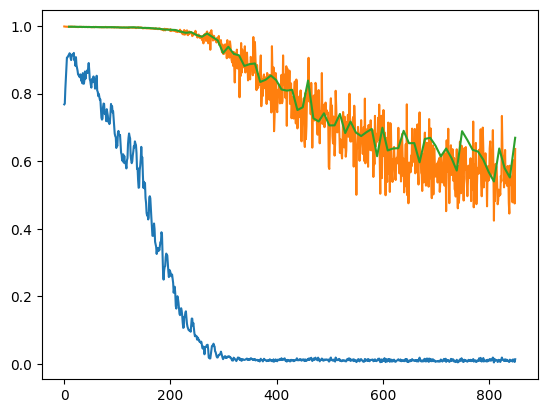

850 851 852 853 854 855 856 857 858 859 859 torch.Size([100, 128, 192, 192])
860 861 862 863 864 865 866 867 868 869 869 torch.Size([100, 128, 192, 192])
870 871 872 873 874 875 876 877 878 879 879 torch.Size([100, 128, 192, 192])
880 881 882 883 884 885 886 887 888 889 889 torch.Size([100, 128, 192, 192])
890 891 892 893 894 895 896 897 898 899 899 torch.Size([100, 128, 192, 192])


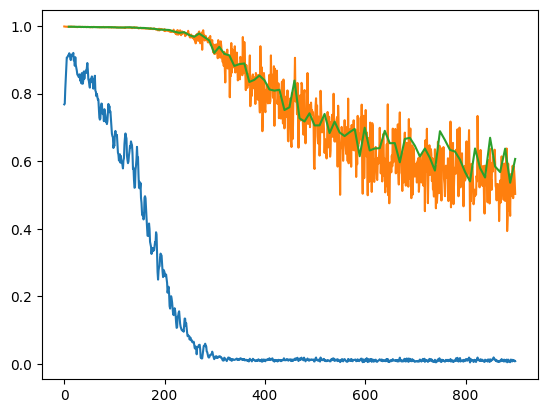

900 901 902 903 904 905 906 907 908 909 909 torch.Size([100, 128, 192, 192])
910 911 912 913 914 915 916 917 918 919 919 torch.Size([100, 128, 192, 192])
920 921 922 923 924 925 926 927 928 929 929 torch.Size([100, 128, 192, 192])
930 931 932 933 934 935 936 937 938 939 939 torch.Size([100, 128, 192, 192])
940 941 942 943 944 945 946 947 948 949 949 torch.Size([100, 128, 192, 192])


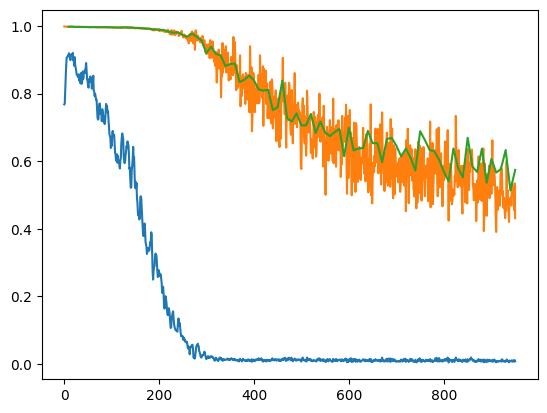

950 951 952 953 954 955 956 957 958 959 959 torch.Size([100, 128, 192, 192])
960 961 962 963 964 965 966 967 968 969 969 torch.Size([100, 128, 192, 192])
970 971 972 973 974 975 976 977 978 979 979 torch.Size([100, 128, 192, 192])
980 981 982 983 984 985 986 987 988 989 989 torch.Size([100, 128, 192, 192])
990 991 992 993 994 995 996 997 998 999 999 torch.Size([100, 128, 192, 192])


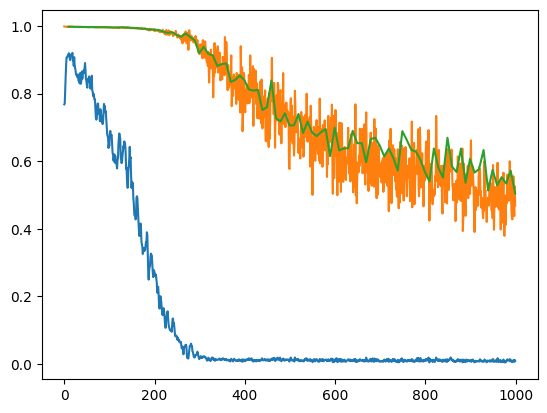

1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1009 torch.Size([100, 128, 192, 192])
1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1019 torch.Size([100, 128, 192, 192])
1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1029 torch.Size([100, 128, 192, 192])
1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1039 torch.Size([100, 128, 192, 192])
1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1049 torch.Size([100, 128, 192, 192])


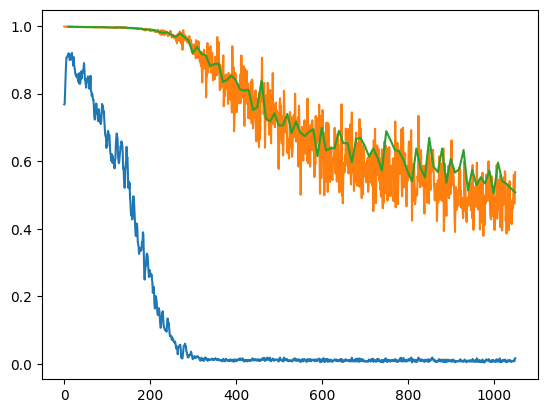

1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1059 torch.Size([100, 128, 192, 192])
1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1069 torch.Size([100, 128, 192, 192])
1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1079 torch.Size([100, 128, 192, 192])
1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1089 torch.Size([100, 128, 192, 192])
1090 1091 1092 1093 1094 1095 1096 1097 1098 1099 1099 torch.Size([100, 128, 192, 192])


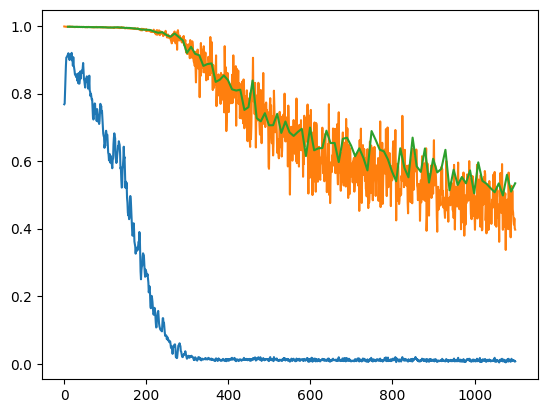

1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1109 torch.Size([100, 128, 192, 192])
1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1119 torch.Size([100, 128, 192, 192])
1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1129 torch.Size([100, 128, 192, 192])
1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1139 torch.Size([100, 128, 192, 192])
1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1149 torch.Size([100, 128, 192, 192])


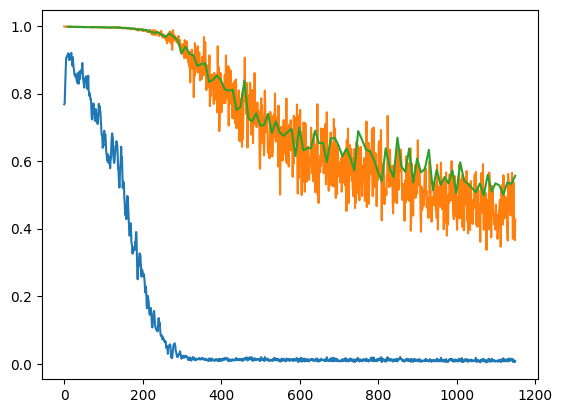

1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1159 torch.Size([100, 128, 192, 192])
1160 1161 1162 1163 1164 1165 1166 1167 1168 1169 1169 torch.Size([100, 128, 192, 192])
1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1179 torch.Size([100, 128, 192, 192])
1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1189 torch.Size([100, 128, 192, 192])
1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1199 torch.Size([100, 128, 192, 192])


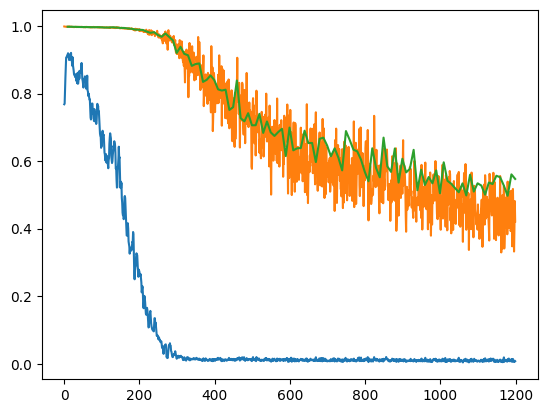

1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1209 torch.Size([100, 128, 192, 192])
1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1219 torch.Size([100, 128, 192, 192])
1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1229 torch.Size([100, 128, 192, 192])
1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1239 torch.Size([100, 128, 192, 192])
1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1249 torch.Size([100, 128, 192, 192])


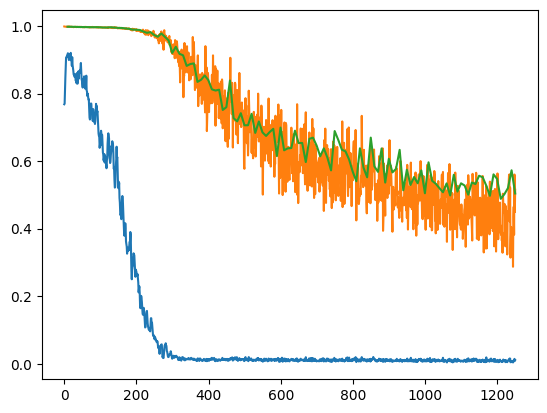

1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1259 torch.Size([100, 128, 192, 192])
1260 1261 1262 1263 1264 1265 1266 1267 1268 1269 1269 torch.Size([100, 128, 192, 192])
1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1279 torch.Size([100, 128, 192, 192])
1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1289 torch.Size([100, 128, 192, 192])
1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1299 torch.Size([100, 128, 192, 192])


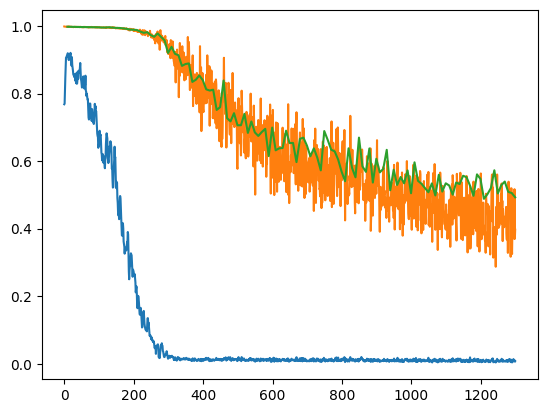

1300 1301 1302 1303 1304 1305 1306 1307 1308 1309 1309 torch.Size([100, 128, 192, 192])
1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1319 torch.Size([100, 128, 192, 192])
1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1329 torch.Size([100, 128, 192, 192])
1330 1331 1332 1333 1334 1335 1336 1337 1338 1339 1339 torch.Size([100, 128, 192, 192])
1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1349 torch.Size([100, 128, 192, 192])


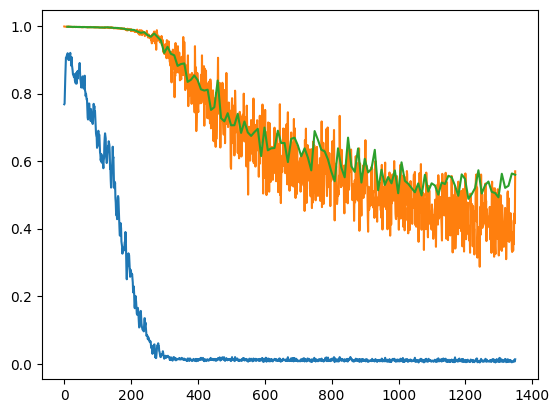

1350 1351 1352 1353 1354 1355 1356 1357 1358 1359 1359 torch.Size([100, 128, 192, 192])
1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1369 torch.Size([100, 128, 192, 192])
1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1379 torch.Size([100, 128, 192, 192])
1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1389 torch.Size([100, 128, 192, 192])
1390 1391 1392 1393 1394 1395 1396 1397 1398 1399 1399 torch.Size([100, 128, 192, 192])


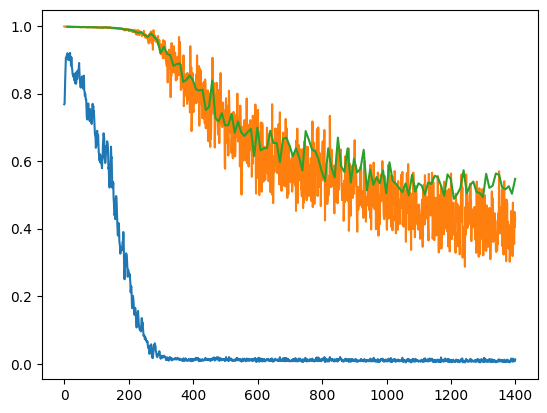

1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1409 torch.Size([100, 128, 192, 192])
1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1419 torch.Size([100, 128, 192, 192])
1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1429 torch.Size([100, 128, 192, 192])
1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1439 torch.Size([100, 128, 192, 192])
1440 1441 1442 1443 1444 1445 1446 1447 1448 1449 1449 torch.Size([100, 128, 192, 192])


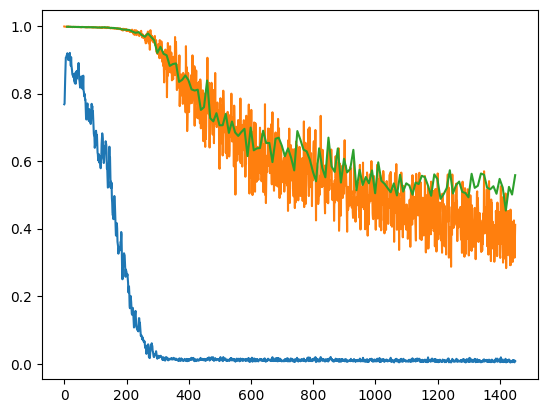

1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1459 torch.Size([100, 128, 192, 192])
1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1469 torch.Size([100, 128, 192, 192])
1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1479 torch.Size([100, 128, 192, 192])
1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1489 torch.Size([100, 128, 192, 192])
1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1499 torch.Size([100, 128, 192, 192])


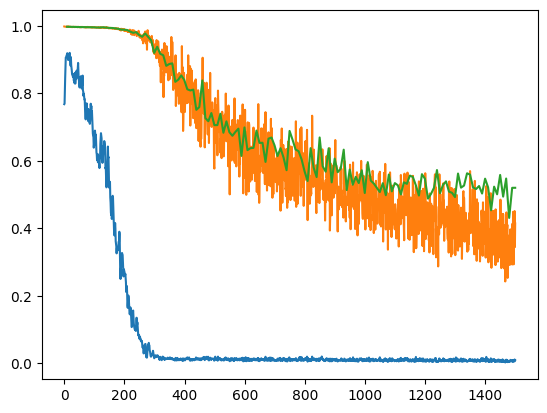

1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 1509 torch.Size([100, 128, 192, 192])
1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1519 torch.Size([100, 128, 192, 192])
1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1529 torch.Size([100, 128, 192, 192])
1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1539 torch.Size([100, 128, 192, 192])
1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1549 torch.Size([100, 128, 192, 192])


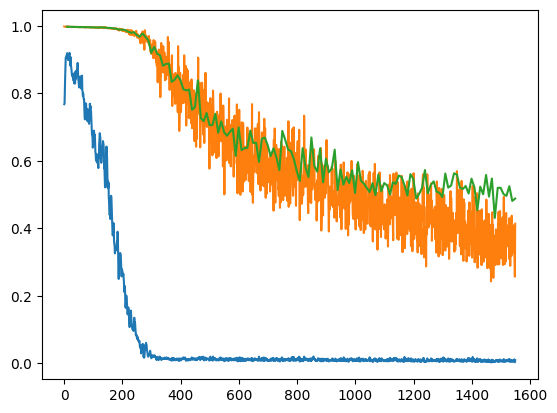

1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1559 torch.Size([100, 128, 192, 192])
1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1569 torch.Size([100, 128, 192, 192])
1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1579 torch.Size([100, 128, 192, 192])
1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1589 torch.Size([100, 128, 192, 192])
1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1599 torch.Size([100, 128, 192, 192])


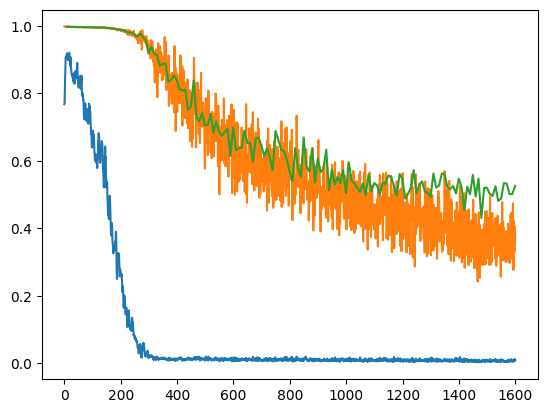

1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1609 torch.Size([100, 128, 192, 192])
1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1619 torch.Size([100, 128, 192, 192])
1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1629 torch.Size([100, 128, 192, 192])
1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1639 torch.Size([100, 128, 192, 192])
1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1649 torch.Size([100, 128, 192, 192])


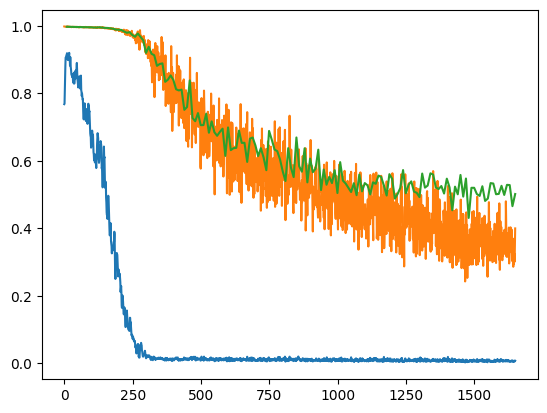

1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1659 torch.Size([100, 128, 192, 192])
1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1669 torch.Size([100, 128, 192, 192])
1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1679 torch.Size([100, 128, 192, 192])
1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1689 torch.Size([100, 128, 192, 192])
1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1699 torch.Size([100, 128, 192, 192])


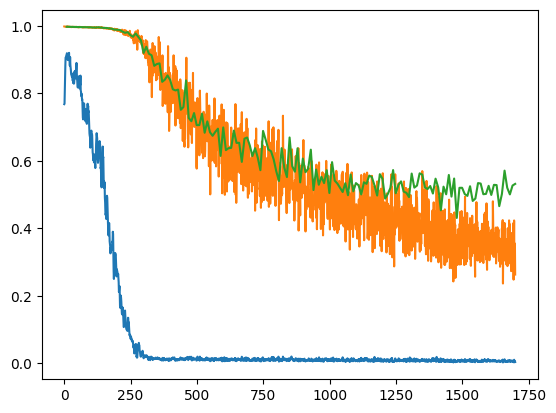

1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1709 torch.Size([100, 128, 192, 192])
1710 1711 1712 1713 1714 1715 1716 1717 1718 1719 1719 torch.Size([100, 128, 192, 192])
1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1729 torch.Size([100, 128, 192, 192])
1730 1731 1732 1733 1734 1735 1736 1737 1738 1739 1739 torch.Size([100, 128, 192, 192])
1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1749 torch.Size([100, 128, 192, 192])


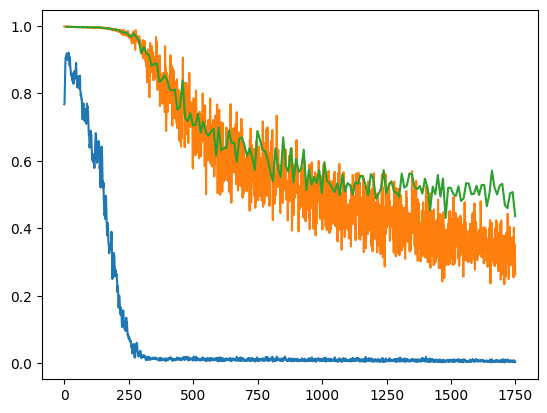

1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1759 torch.Size([100, 128, 192, 192])
1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1769 torch.Size([100, 128, 192, 192])
1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1779 torch.Size([100, 128, 192, 192])
1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1789 torch.Size([100, 128, 192, 192])
1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1799 torch.Size([100, 128, 192, 192])


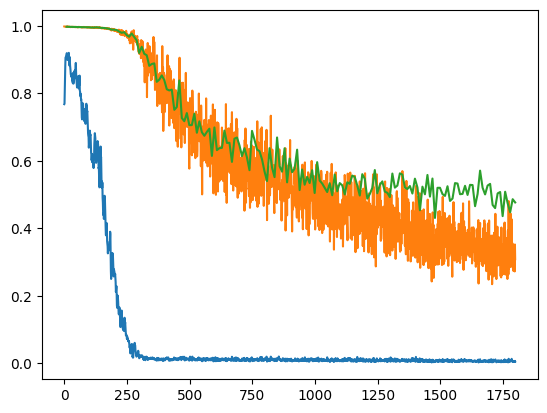

1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1809 torch.Size([100, 128, 192, 192])
1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1819 torch.Size([100, 128, 192, 192])
1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1829 torch.Size([100, 128, 192, 192])
1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1839 torch.Size([100, 128, 192, 192])
1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1849 torch.Size([100, 128, 192, 192])


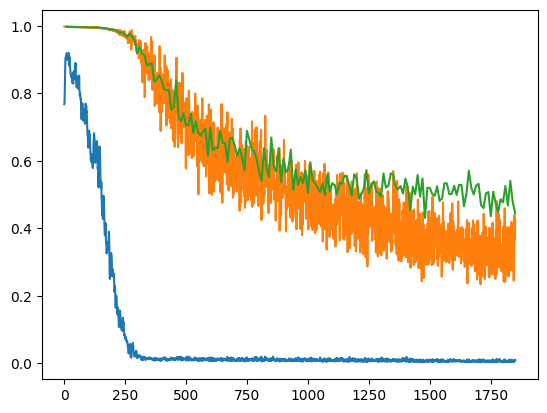

1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1859 torch.Size([100, 128, 192, 192])
1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1869 torch.Size([100, 128, 192, 192])
1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1879 torch.Size([100, 128, 192, 192])
1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1889 torch.Size([100, 128, 192, 192])
1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1899 torch.Size([100, 128, 192, 192])


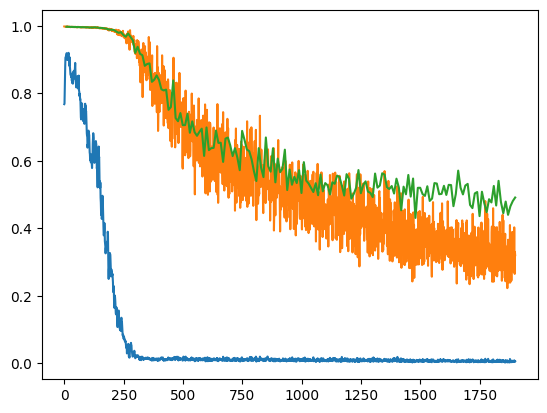

1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1909 torch.Size([100, 128, 192, 192])
1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1919 torch.Size([100, 128, 192, 192])
1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1929 torch.Size([100, 128, 192, 192])
1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1939 torch.Size([100, 128, 192, 192])
1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1949 torch.Size([100, 128, 192, 192])


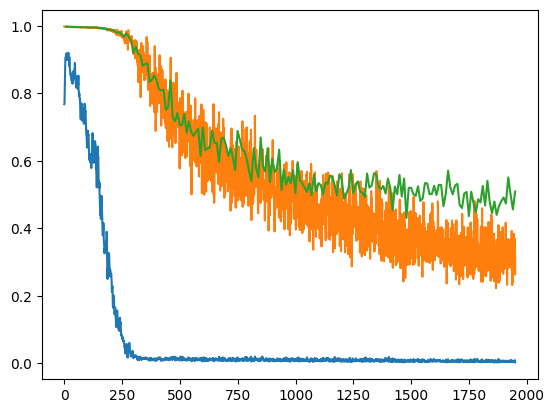

1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1959 torch.Size([100, 128, 192, 192])
1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1969 torch.Size([100, 128, 192, 192])
1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1979 torch.Size([100, 128, 192, 192])
1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1989 torch.Size([100, 128, 192, 192])
1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 1999 torch.Size([100, 128, 192, 192])


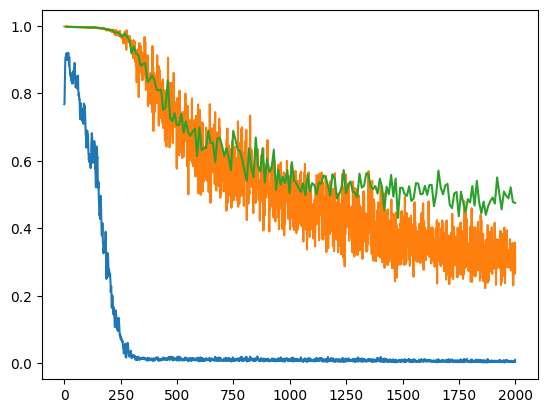

 
0.6732673267326733


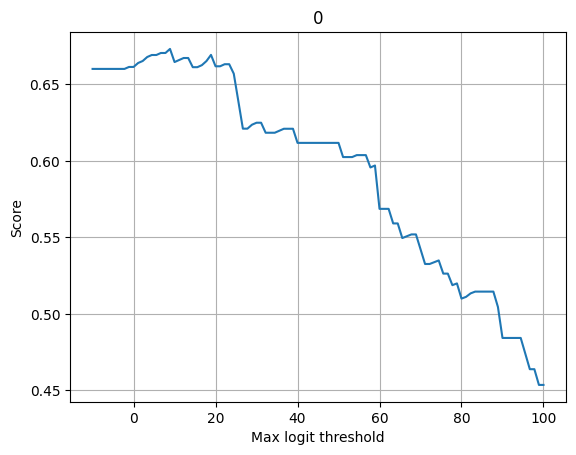

ii 1
0 

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\torch\utils\data\_utils\fetch.py", line 33, in fetch
    data.append(next(self.dataset_iter))
  File "d:\flagellar/code/core\flg_unet.py", line 164, in __iter__
    yield get_next()
  File "C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "d:\flagellar/code/core\flg_support.py", line 195, in profile_each_line
    return func(*args, **kwargs)
  File "d:\flagellar/code/core\flg_unet.py", line 145, in get_next
    image = torch.tensor(image, dtype=torch.float16)
ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 


In [3]:
#importlib.reload(flg_unet)
N=5
if fast_mode: N=1
for ii in range(N):
    print('ii', ii)
    model = flg_model.ThreeStepModel()
    model.step1Heatmap.plot_every = 50
    model.step1Heatmap.entropy_weight = 0
    if fast_mode: model.step1Heatmap.n_epochs = 3
    model.step2Labels.threshold = -2.
    model.train(train_data, test_data)
    print(' ')
    inferred_test_data = model.infer(test_data)
    print(fls.score_competition_metric(inferred_test_data, test_data))
    if not fast_mode:
        fls.dill_save(fls.model_dir + 'model_voxelbug' + str(ii) + '.pickle', (model, fls.score_competition_metric(inferred_test_data, test_data)))
    plt.title(str(ii))
    plt.pause(0.1)

In [ ]:
model.infer(fls.load_all_test_data()[1:3])